In [1]:
import geoplotlib
from linelayer import LineLayer
from geoplotlib.utils import DataAccessObject, BoundingBox
from pandas import DataFrame, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import matplotlib
from IPython.display import display
from geopy.distance import vincenty
from sklearn.cluster import DBSCAN

# Enable inline plotting
%matplotlib inline

# antialiasing for geoplotlib
geoplotlib.set_smoothing(True)

ImportError: Library "GL" not found.

In [2]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 2.7.12 (v2.7.12:d33e0cf91556, Jun 27 2016, 15:24:40) [MSC v.1500 64 bit (AMD64)]
Pandas version 0.18.1
Matplotlib version 1.5.1


## Initialization

In [3]:
# First priority: jumps and random, jittered movement
bike_file = "C:/Users/dknodt/Projekte/Movement Data Errors/datasets/CDC2013/traj_days_30min_clean75kmh_gap1km.csv"
tram_file = "C:/Users/dknodt/Projekte/Movement Data Errors/datasets/W-trams/20160321_tramwaje.csv"
# car trajectories in rectangular cell => problems at the borders
milan_file = "C:\Users\dknodt\Projekte\Movement Data Errors\datasets\Milano\m30_20070404_end_06_10_f_data.csv"
st_aug_jumps_file = "C:\Users\dknodt\Downloads\sankt_augustin_jumps.csv"
st_aug_no_jumps_file = "C:\Users\dknodt\Downloads\sankt_augustin_without_jumps.csv"

In [4]:
df = pd.read_csv(bike_file, header=0, names=['trID', 'trN', 'pIdx', 'lon', 'lat', 'time', 'Duration'])
ignored_columns = ['Duration']
df = df[[c for c in df.columns if c not in ignored_columns ]]
df['time'] = pd.to_datetime(df['time'], format="%d/%m/%Y %H:%M:%S")
df = df.set_index(pd.DatetimeIndex(df['time']))
print len(df)
print(df.head(20))

722635
                          trID  trN  pIdx       lon        lat  \
2011-10-08 12:45:25  101_  3_1    1     1 -1.607602  55.004017   
2011-10-08 12:45:30  101_  3_1    1     2 -1.607632  55.003990   
2011-10-08 12:47:10  101_  3_1    1     3 -1.607506  55.004080   
2011-10-08 12:47:15  101_  3_1    1     4 -1.607435  55.004078   
2011-10-08 12:48:40  101_  3_1    1     5 -1.607548  55.004110   
2011-10-08 12:54:15  101_  3_1    1     6 -1.607383  55.004097   
2011-10-08 12:54:20  101_  3_1    1     7 -1.607390  55.004017   
2011-10-08 12:54:25  101_  3_1    1     8 -1.607375  55.004050   
2011-10-08 12:56:15  101_  3_1    1     9 -1.607365  55.004090   
2011-10-08 12:56:20  101_  3_1    1    10 -1.607372  55.004130   
2011-10-08 12:56:25  101_  3_1    1    11 -1.607404  55.004253   
2011-10-08 12:56:30  101_  3_1    1    12 -1.607626  55.004303   
2011-10-08 12:56:35  101_  3_1    1    13 -1.607975  55.004250   
2011-10-08 12:56:40  101_  3_1    1    14 -1.608341  55.004190   
201

## Raw plots

In [16]:
# dot plot of all trajectory points
geoplotlib.dot(df, color=[0,0,0])
geoplotlib.show()

In [20]:
# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))
geoplotlib.show()

## Calculate additional attributes

### cumulative angle alpha 

In [5]:
window = 20
# window = 5

groups = df.groupby('trID')
frames = []
print 'groups', len(groups)
# for each trajectory
for i, (grp_id, grp_df) in enumerate(groups):
    tmp_df = grp_df.copy()
    lon_lat_df = tmp_df[['lon', 'lat']]
    # add next point to record
    tmp_df[['lon+1', 'lat+1']] = lon_lat_df.shift(-1)
    # difference vector
    tmp_df['v_lon'] = tmp_df['lon+1'] - tmp_df['lon']
    tmp_df['v_lat'] = tmp_df['lat+1'] - tmp_df['lat']
    # normalize difference vectort
    norm_vec = np.linalg.norm(tmp_df[['v_lon','v_lat']], axis=1)
    mat = np.array(tmp_df[['v_lon','v_lat']])
    normalized_mat = mat / norm_vec[:, None]
    tmp_df['norm_v_lon'] = normalized_mat[:, 0]
    tmp_df['norm_v_lat'] = normalized_mat[:, 1]
    # add normalized difference vector of the next point
    v_df = tmp_df[['norm_v_lon', 'norm_v_lat']]
    tmp_df[['norm_v_lon-1', 'norm_v_lat-1']] = v_df.shift(1)
    # calculate angle
    tmp_df['alpha'] = np.arccos(map(np.dot, np.array(tmp_df[['norm_v_lon', 'norm_v_lat']]),
                                    np.array(tmp_df[['norm_v_lon-1', 'norm_v_lat-1']])))
    tmp_df['alpha'] = tmp_df['alpha'].fillna(0)
    frames.append(tmp_df)

df = pd.concat(frames)
# df = df.join(result[['v_lon', 'v_lat', 'alpha', 'pIdx']], on='pIdx')

df['cum_alpha'] = df['alpha'].rolling(window=window).sum().fillna(0);
df = df.fillna(0)
display(df.head(6))

groups 1584


,trID,trN,pIdx,lon,lat,time,lon+1,lat+1,v_lon,v_lat,norm_v_lon,norm_v_lat,norm_v_lon-1,norm_v_lat-1,alpha,cum_alpha
2011-10-08 12:45:25,101_ 3_1,1,1,-1.607602,55.004017,2011-10-08 12:45:25,-1.607632,55.003990,-0.000030,-0.000027,-0.743294,-0.668965,0.000000,0.000000,0.000000,0.0
2011-10-08 12:45:30,101_ 3_1,1,2,-1.607632,55.003990,2011-10-08 12:45:30,-1.607506,55.004080,0.000125,0.000090,0.811977,0.583690,-0.743294,-0.668965,3.032043,0.0
2011-10-08 12:47:10,101_ 3_1,1,3,-1.607506,55.004080,2011-10-08 12:47:10,-1.607435,55.004078,0.000072,-0.000002,0.999612,-0.027844,0.811977,0.583690,0.651113,0.0
2011-10-08 12:47:15,101_ 3_1,1,4,-1.607435,55.004078,2011-10-08 12:47:15,-1.607548,55.004110,-0.000114,0.000032,-0.962665,0.270697,0.999612,-0.027844,2.895324,0.0
2011-10-08 12:48:40,101_ 3_1,1,5,-1.607548,55.004110,2011-10-08 12:48:40,-1.607383,55.004097,0.000165,-0.000013,0.996914,-0.078497,-0.962665,0.270697,2.946054,0.0
2011-10-08 12:54:15,101_ 3_1,1,6,-1.607383,55.004097,2011-10-08 12:54:15,-1.607390,55.004017,-0.000007,-0.000080,-0.080983,-0.996715,0.996914,-0.078497,1.573290,0.0


### cum_alpha statistics

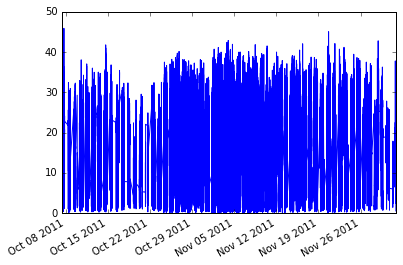

In [19]:
df['cum_alpha'].plot()

In [21]:
df['cum_alpha'].describe()

count    722635.000000
mean         13.255733
std           8.860451
min           0.000000
25%           5.062663
50%          12.270590
75%          20.779023
max          45.847707
Name: cum_alpha, dtype: float64

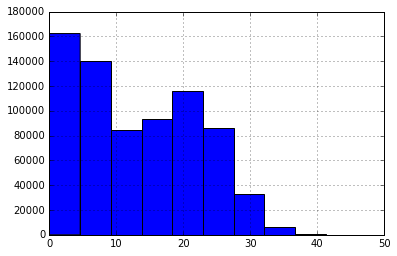

In [22]:
df['cum_alpha'].hist()

## duration

In [23]:
from time import strftime

groups = df.groupby('trID')
frames = []
print 'groups', len(groups)
for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['time+1'] = tmp_df['time'].shift(-1)
    tmp_df['duration'] = tmp_df['time+1'] - tmp_df['time']
    frames.append(tmp_df)
df = pd.concat(frames)
df['duration'] = df['duration'] / np.timedelta64(1, 's')

groups 1584


#### Plotting duration

- time deltas between two consecutive points are mostly 5 seconds

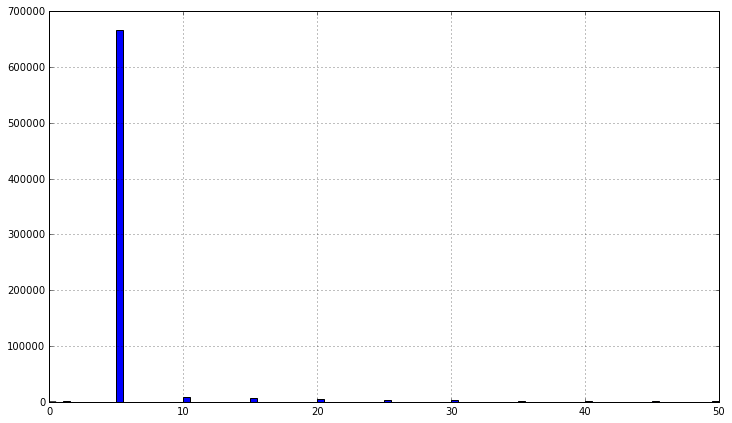

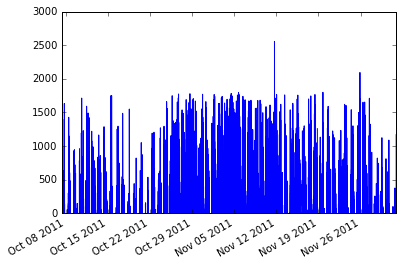

count    721051.000000
mean         10.340868
std          47.931571
min           1.000000
25%                NaN
50%                NaN
75%                NaN
max        2557.000000
Name: duration, dtype: float64


c:\program files\python27\lib\site-packages\numpy\lib\function_base.py:3835: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,trID,trN,pIdx,lon,lat,time,lon+1,lat+1,v_lon,v_lat,norm_v_lon,norm_v_lat,norm_v_lon-1,norm_v_lat-1,alpha,cum_alpha,time+1,duration
2011-10-08 12:45:25,101_ 3_1,1,1,-1.607602,55.004017,2011-10-08 12:45:25,-1.607632,55.003990,-0.000030,-0.000027,-0.743294,-0.668965,0.000000,0.000000,0.000000,0.0,2011-10-08 12:45:30,5.0
2011-10-08 12:45:30,101_ 3_1,1,2,-1.607632,55.003990,2011-10-08 12:45:30,-1.607506,55.004080,0.000125,0.000090,0.811977,0.583690,-0.743294,-0.668965,3.032043,0.0,2011-10-08 12:47:10,100.0
2011-10-08 12:47:10,101_ 3_1,1,3,-1.607506,55.004080,2011-10-08 12:47:10,-1.607435,55.004078,0.000072,-0.000002,0.999612,-0.027844,0.811977,0.583690,0.651113,0.0,2011-10-08 12:47:15,5.0
2011-10-08 12:47:15,101_ 3_1,1,4,-1.607435,55.004078,2011-10-08 12:47:15,-1.607548,55.004110,-0.000114,0.000032,-0.962665,0.270697,0.999612,-0.027844,2.895324,0.0,2011-10-08 12:48:40,85.0
2011-10-08 12:48:40,101_ 3_1,1,5,-1.607548,55.004110,2011-10-08 12:48:40,-1.607383,55.004097,0.000165,-0.000013,0.996914,-0.078497,-0.962665,0.270697,2.946054,0.0,2011-10-08 12:54:15,335.0
2011-10-08 12:54:15,101_ 3_1,1,6,-1.607383,55.004097,2011-10-08 12:54:15,-1.607390,55.004017,-0.000007,-0.000080,-0.080983,-0.996715,0.996914,-0.078497,1.573290,0.0,2011-10-08 12:54:20,5.0
2011-10-08 12:54:20,101_ 3_1,1,7,-1.607390,55.004017,2011-10-08 12:54:20,-1.607375,55.004050,0.000015,0.000033,0.411513,0.911404,-0.080983,-0.996715,2.798551,0.0,2011-10-08 12:54:25,5.0
2011-10-08 12:54:25,101_ 3_1,1,8,-1.607375,55.004050,2011-10-08 12:54:25,-1.607365,55.004090,0.000010,0.000040,0.233373,0.972387,0.411513,0.911404,0.188568,0.0,2011-10-08 12:56:15,110.0
2011-10-08 12:56:15,101_ 3_1,1,9,-1.607365,55.004090,2011-10-08 12:56:15,-1.607372,55.004130,-0.000007,0.000040,-0.169989,0.985446,0.233373,0.972387,0.406364,0.0,2011-10-08 12:56:20,5.0
2011-10-08 12:56:20,101_ 3_1,1,10,-1.607372,55.004130,2011-10-08 12:56:20,-1.607404,55.004253,-0.000032,0.000123,-0.250306,0.968167,-0.169989,0.985446,0.082178,0.0,2011-10-08 12:56:25,5.0


In [24]:
df['duration'].hist(bins=100, figsize=(12,7), range=(0,50))
plt.show()
df['duration'].plot()
plt.show()
print df['duration'].describe()
display(df.head(10))

## distance

In [25]:
def calc_distance(a):
    lat_1, lon_1, lat_2, lon_2 = a
    return vincenty((lat_1, lon_1), (lat_2, lon_2)).meters

# lat, lon geopy.distance
print df[['lat', 'lon', 'lat+1', 'lon+1']].head(10)
df['distance'] = df[['lat', 'lon', 'lat+1', 'lon+1']].apply(calc_distance, axis=1)
df.head()

                           lat       lon      lat+1     lon+1
2011-10-08 12:45:25  55.004017 -1.607602  55.003990 -1.607632
2011-10-08 12:45:30  55.003990 -1.607632  55.004080 -1.607506
2011-10-08 12:47:10  55.004080 -1.607506  55.004078 -1.607435
2011-10-08 12:47:15  55.004078 -1.607435  55.004110 -1.607548
2011-10-08 12:48:40  55.004110 -1.607548  55.004097 -1.607383
2011-10-08 12:54:15  55.004097 -1.607383  55.004017 -1.607390
2011-10-08 12:54:20  55.004017 -1.607390  55.004050 -1.607375
2011-10-08 12:54:25  55.004050 -1.607375  55.004090 -1.607365
2011-10-08 12:56:15  55.004090 -1.607365  55.004130 -1.607372
2011-10-08 12:56:20  55.004130 -1.607372  55.004253 -1.607404


,trID,trN,pIdx,lon,lat,time,lon+1,lat+1,v_lon,v_lat,norm_v_lon,norm_v_lat,norm_v_lon-1,norm_v_lat-1,alpha,cum_alpha,time+1,duration,distance
2011-10-08 12:45:25,101_ 3_1,1,1,-1.607602,55.004017,2011-10-08 12:45:25,-1.607632,55.003990,-0.000030,-0.000027,-0.743294,-0.668965,0.000000,0.000000,0.000000,0.0,2011-10-08 12:45:30,5.0,3.566432
2011-10-08 12:45:30,101_ 3_1,1,2,-1.607632,55.003990,2011-10-08 12:45:30,-1.607506,55.004080,0.000125,0.000090,0.811977,0.583690,-0.743294,-0.668965,3.032043,0.0,2011-10-08 12:47:10,100.0,12.828211
2011-10-08 12:47:10,101_ 3_1,1,3,-1.607506,55.004080,2011-10-08 12:47:10,-1.607435,55.004078,0.000072,-0.000002,0.999612,-0.027844,0.811977,0.583690,0.651113,0.0,2011-10-08 12:47:15,5.0,4.599698
2011-10-08 12:47:15,101_ 3_1,1,4,-1.607435,55.004078,2011-10-08 12:47:15,-1.607548,55.004110,-0.000114,0.000032,-0.962665,0.270697,0.999612,-0.027844,2.895324,0.0,2011-10-08 12:48:40,85.0,8.106461
2011-10-08 12:48:40,101_ 3_1,1,5,-1.607548,55.004110,2011-10-08 12:48:40,-1.607383,55.004097,0.000165,-0.000013,0.996914,-0.078497,-0.962665,0.270697,2.946054,0.0,2011-10-08 12:54:15,335.0,10.663005


## velocity

In [26]:
df['velocity'] = 3.6 * np.divide(df['distance'], df['duration'])
df['velocity'].describe()

count    721051.000000
mean         10.960343
std          12.035251
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max          89.686928
Name: velocity, dtype: float64

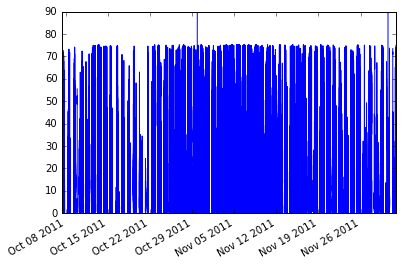

In [27]:
df['velocity'].plot()

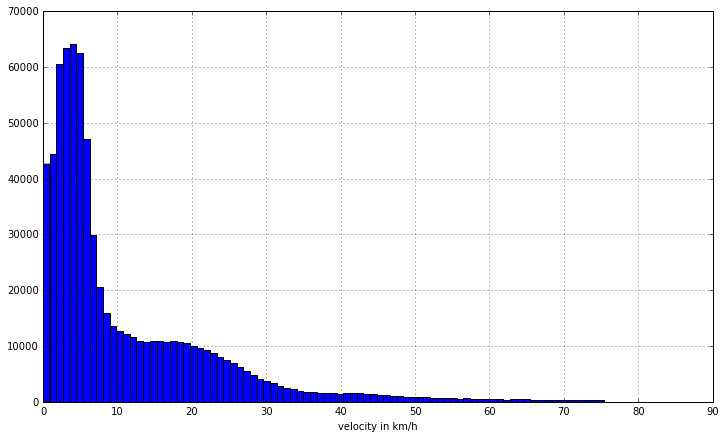

In [28]:
ax = df['velocity'].hist(figsize=(12,7), bins=100)
ax.set_xlabel("velocity in km/h")

### draw points whose velocity exceeds threshold

#### threshold 35 km/h

In [29]:
v_threshold = 35

# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))

# dot plot of all possible jump points
fast_dict = DataAccessObject.from_dataframe(df[df['velocity'] > v_threshold])
print len(fast_dict)

def alpha_tooltip(p):
    return "velocity: {} trid: {}".format(np.round(p['velocity'], 1), p['trID'])
geoplotlib.dot(fast_dict, point_size=3, f_tooltip=alpha_tooltip)
geoplotlib.show()

36381


#### threshold 5 km/h

In [30]:
v_threshold = 5

# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))

# dot plot of all possible jump points
slow_dict = DataAccessObject.from_dataframe(df[df['velocity'] < v_threshold])
print len(fast_dict)

def alpha_tooltip(p):
    return "velocity: {} trid: {}".format(np.round(p['velocity'], 1), p['trID'])
geoplotlib.dot(slow_dict, point_size=3, f_tooltip=alpha_tooltip)
geoplotlib.show()

36381


#### classify line segments according to their velocity

- <b>velocity < 5</b> : slow (color: blue)
- <b>5 < velocity < 15</b> : medium (color: green) 
- <b>velocity > 35</b> : fast (color: red) 

In [31]:
v_threshold1 = 5
v_threshold2 = 15

# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    slow_df = grp_df[grp_df['velocity'] < v_threshold1]
    medium_df = grp_df[(grp_df['velocity'] >= v_threshold1) & (grp_df['velocity'] < v_threshold2)]
    fast_df = grp_df[grp_df['velocity'] >= v_threshold2]
    if len(slow_df) > 0:
        geoplotlib.graph(slow_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,0,255])
    if len(fast_df) > 0:
        geoplotlib.graph(fast_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[255,0,0])
    if len(medium_df) > 0:
        geoplotlib.graph(medium_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,255,0])

geoplotlib.show()

## bounding box diagonal

In [33]:
window = 15
groups = df.groupby('trID')
frames = []

for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['min_bounding_lat'] = tmp_df['lat'].rolling(window=window).min()
    tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
    tmp_df['min_bounding_lon'] = tmp_df['lon'].rolling(window=window).min()
    tmp_df['max_bounding_lon'] = tmp_df['lon'].rolling(window=window).max()
    tmp_df['bb_diag'] = ((tmp_df['max_bounding_lon'] - tmp_df['min_bounding_lon'])**2 + (tmp_df['max_bounding_lat'] - tmp_df['min_bounding_lat'])**2)**0.5
    frames.append(tmp_df)
df = pd.concat(frames)

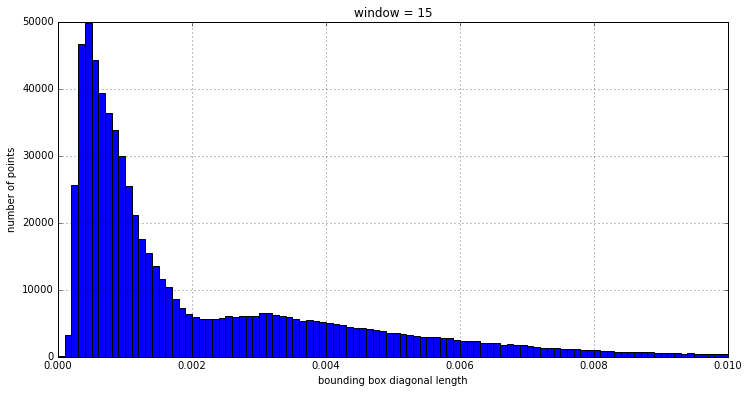

In [34]:
ax = df['bb_diag'].dropna().hist(bins=100, range=(0,0.01), figsize=(12,6))
ax.set_title('window = {}'.format(window))
ax.set_xlabel('bounding box diagonal length')
ax.set_ylabel('number of points')

#### Classify line segments according to the bounding box diagonal length

- length in lat and lon units
- 3 classes with thresholds
    - bb_threshold1 = 0.0015
    - bb_threshold2 = 0.002

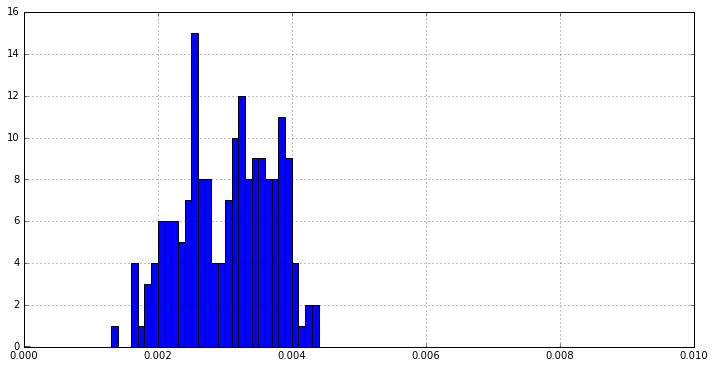

In [35]:
bb_threshold1 = 0.0015
bb_threshold2 = 0.002

# line plot of trajectories
i=0
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    grp_df = grp_df.iloc[:-1]
    if i == 0:
        ax = grp_df['bb_diag'].dropna().hist(bins=100, range=(0,0.01), figsize=(12,6))
    i+=1
    slow_df = grp_df[grp_df['bb_diag'] < bb_threshold1]
    medium_df = grp_df[(grp_df['bb_diag'] >= bb_threshold1) & (grp_df['bb_diag'] < bb_threshold2)]
    fast_df = grp_df[grp_df['bb_diag'] >= bb_threshold2]
    if len(slow_df) > 0:
        geoplotlib.graph(slow_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,0,255])
        
    if len(fast_df) > 0:
        geoplotlib.graph(fast_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[255,0,0])

    if len(medium_df) > 0:
        geoplotlib.graph(medium_df, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,255,0])

geoplotlib.show()

## DBSCAN clustering

count    7.226350e+05
mean     1.336394e+04
std      2.847792e+05
min      0.000000e+00
25%      4.911464e+00
50%      8.585351e+00
75%      2.277579e+01
max      6.210124e+06
Name: distance, dtype: float64

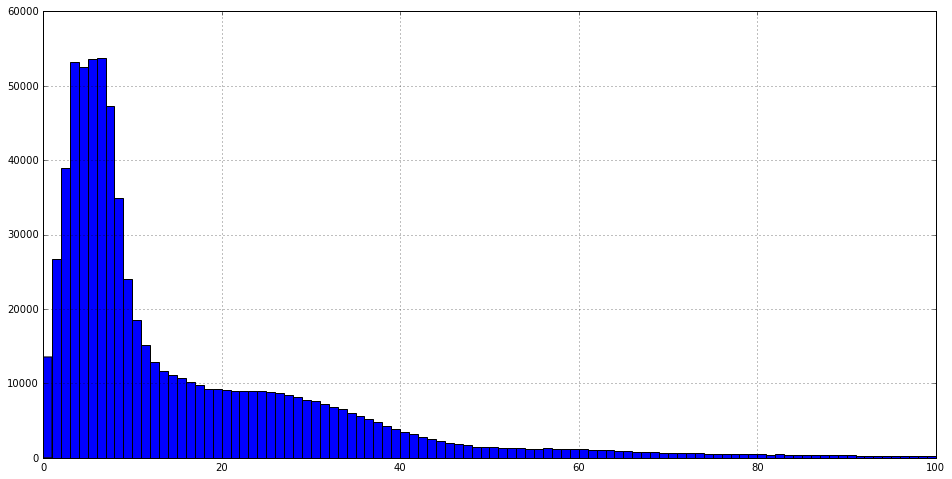

In [16]:
df['distance'].hist(bins=100, figsize=(16,8), range=(0,100))
df['distance'].describe()

In [11]:
duration_threshold = 2400

additional notes to metric:
- timestamp difference > duration_threshold => return infinity
- vincenty distance calculates distance on ellipsoid

### Clustering for one trajectory!

In [13]:
eps = 0.0025
min_samples = 15
n_clusters = []
distances = []

# this is the important part
# x[0]: longitude
# x[1]: latitude
# x[2]: timestamp
# same for y
def stop_metric(x, y):
    duration = abs(x[2]-y[2])
    if duration > duration_threshold:
        return np.inf
    distance = vincenty((x[1], x[0]), (y[1], y[0])).meters
    if (duration < 1e-5):
        return 0
    else:
        distances.append(distance/duration)
        return distance/duration

start = df['time'][0]
groups = df.groupby('trID')

# trajectory id is set here
filter_id = '128_ 26_1'

grp_df = groups.get_group(filter_id)
grp_df = grp_df.copy()
geoplotlib.add_layer(LineLayer(grp_df))

# time_f: seconds from first trajectory point
grp_df['time_f'] = (grp_df['time'] - start)
grp_df['time_f'] = grp_df['time_f'] / np.timedelta64(1, 's')
X = np.array(grp_df[['lon', 'lat', 'time_f']])

# Clustering using own metric
print 'before DBScan'
db = DBSCAN(eps=eps, min_samples=min_samples, metric=stop_metric).fit(X)
print 'after DBScan'

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print 'number of cluster: {}'.format(n_clusters_)
n_clusters.append(n_clusters_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# Plot results
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0,0,0]
    else:
        col = [int(c * 255) for c in col[:3]]
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
        geoplotlib.dot({
            'lon' : xy[:, 0],
            'lat' : xy[:, 1]
        }, color=col, point_size=3)

    xy = X[class_member_mask & ~core_samples_mask]
    if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
        geoplotlib.dot({
            'lon' : xy[:, 0],
            'lat' : xy[:, 1]
        }, color=col, point_size=3)
ds = pd.Series(distances)
geoplotlib.show()

vor DBScan
nach DBScan
number of cluster: 2


## Try many epsilons for clustering

In [ ]:
eps = 0.1
min_samples = 8
n_clusters = []
def stop_metric(x, y):
    duration = abs(x[2]-y[2])
    if duration > duration_threshold:
        return np.inf
    distance = vincenty((x[1], x[0]), (y[1], y[0])).meters
#     print (x[1], x[0]), (y[1], y[0])
#     print 'distance', distance, 'duration', duration, distance/duration
#     if (distance < 1e-5 and duration < 1e-5):
    if (duration < 1e-5):
        return 0
    else:
        distances.append(distance/duration)
        return distance/duration

for eps in np.arange(0.2,0.5,0.025):
    distances = []
    print 'eps', eps
    start = df['time'][0]
    groups = df.groupby('trID')
    # filter_id = '101_  3_1'
    filter_id = '128_ 26_1'
    grp_df = groups.get_group(filter_id)
    grp_df = grp_df.copy()
    geoplotlib.add_layer(LineLayer(grp_df))
    # print 'len group: {}'.format(len(grp_df))

    grp_df['time_f'] = (grp_df['time'] - start)
    grp_df['time_f'] = grp_df['time_f'] / np.timedelta64(1, 's')
    X = np.array(grp_df[['lon', 'lat', 'time_f']])
    print 'vor DBScan'
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=stop_metric).fit(X)
    print 'nach DBScan'

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print 'number of cluster: {}'.format(n_clusters_)
    n_clusters.append(n_clusters_)
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0,0,0]
        else:
            col = [int(c * 255) for c in col[:3]]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
            geoplotlib.dot({
                'lon' : xy[:, 0],
                'lat' : xy[:, 1]
            }, color=col, point_size=3)

        xy = X[class_member_mask & ~core_samples_mask]
        if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
            geoplotlib.dot({
                'lon' : xy[:, 0],
                'lat' : xy[:, 1]
            }, color=col, point_size=2)
    ds = pd.Series(distances)

#geoplotlib.show()

#### plot n_clusters series from above eps tries

In [38]:
cluster_series = pd.Series(n_clusters)
eps_series = pd.Series([0.05 + i * 0.05 for i in range(24)])
n_cluster_df = pd.DataFrame({'n_cluster' : cluster_series, 'eps': eps_series})
n_cluster_df.plot(x='eps', y='n_cluster')

NameError: name 'n_clusters' is not defined

## Try many min_points for clustering

In [ ]:
eps = 0.25
n_clusters = []
def stop_metric(x, y):
    duration = abs(x[2]-y[2])
    if duration > duration_threshold:
        return np.inf
    distance = vincenty((x[1], x[0]), (y[1], y[0])).meters
#     print (x[1], x[0]), (y[1], y[0])
#     print 'distance', distance, 'duration', duration, distance/duration
#     if (distance < 1e-5 and duration < 1e-5):
    if (duration < 1e-5):
        return 0
    else:
        distances.append(distance/duration)
        return distance/duration

for min_samples in range(14,20):
    distances = []
    print 'min_points', min_samples
    start = df['time'][0]
    groups = df.groupby('trID')
    # filter_id = '101_  3_1'
    filter_id = '128_ 26_1'
    grp_df = groups.get_group(filter_id)
    grp_df = grp_df.copy()
    geoplotlib.add_layer(LineLayer(grp_df))
    # print 'len group: {}'.format(len(grp_df))

    grp_df['time_f'] = (grp_df['time'] - start)
    grp_df['time_f'] = grp_df['time_f'] / np.timedelta64(1, 's')
    X = np.array(grp_df[['lon', 'lat', 'time_f']])
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=stop_metric).fit(X)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print 'number of cluster: {}'.format(n_clusters_)
    n_clusters.append(n_clusters_)
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0,0,0]
        else:
            col = [int(c * 255) for c in col[:3]]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
            geoplotlib.dot({
                'lon' : xy[:, 0],
                'lat' : xy[:, 1]
            }, color=col, point_size=3)

        xy = X[class_member_mask & ~core_samples_mask]
        if (len(xy[:, 1]) > 0 and len(xy[:, 0]) > 0):
            geoplotlib.dot({
                'lon' : xy[:, 0],
                'lat' : xy[:, 1]
            }, color=col, point_size=2)
    ds = pd.Series(distances)

#geoplotlib.show()

#### plot n_clusters series from min_points tries

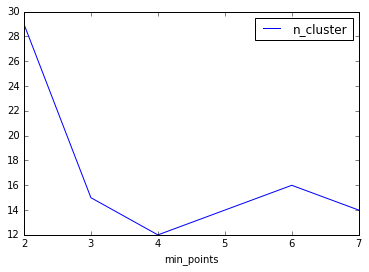

In [32]:
cluster_series = pd.Series(n_clusters)
mp_series = pd.Series(range(2,8))
n_cluster_df = pd.DataFrame({'n_cluster' : cluster_series, 'min_points': mp_series})
n_cluster_df.plot(x='min_points', y='n_cluster')

count    885942.000000
mean          0.779081
std           7.224114
min           0.000000
25%           0.035771
50%           0.088194
75%           0.364136
max        2914.403219
dtype: float64


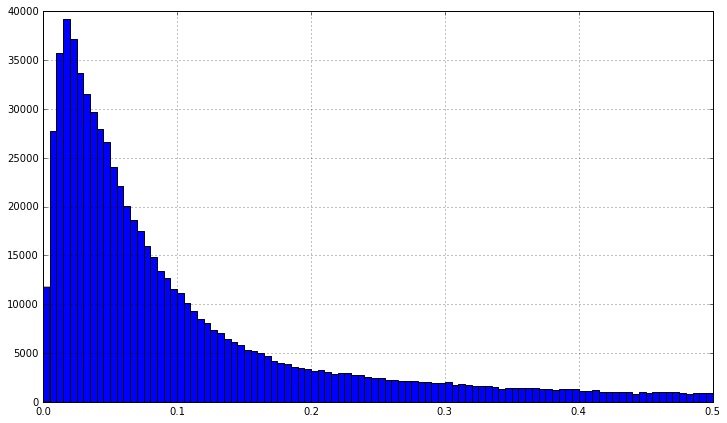

In [20]:
ds.hist(bins=100, range=(0,0.5), figsize=(12,7))
print ds.describe()
plt.show()

# Apply Filter

## Cumulative alpha thresholding

In [39]:
threshold = 9
df_jump = df[df['cum_alpha'] > threshold]

#### dot plot points whose cumulative alpha exceeds the threshold

In [40]:
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))

# dot plot of all possible jump points
jump_dict = DataAccessObject.from_dataframe(df_jump)

def alpha_tooltip(p):
    return "alpha: {} deg: {} cum_alpha: {} time: {}".format(np.round(p['alpha'], 2),
                                                    np.round(p['alpha'] / np.pi * 180, 0),
                                                    np.round(p['cum_alpha'], 1),
                                                    p['time'])
geoplotlib.dot(jump_dict, point_size=3, f_tooltip=alpha_tooltip)
geoplotlib.show()

#### Line plot after removing every point above threshold

In [42]:
df_no_jump = df[df['cum_alpha'] < threshold]
# line plot of corrected trajectories
groups = df_no_jump.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))
geoplotlib.show()

In [ ]:
df['cum_alpha'].to_csv('cum_alpha.csv')

### cumulative alpha histograms for different windows

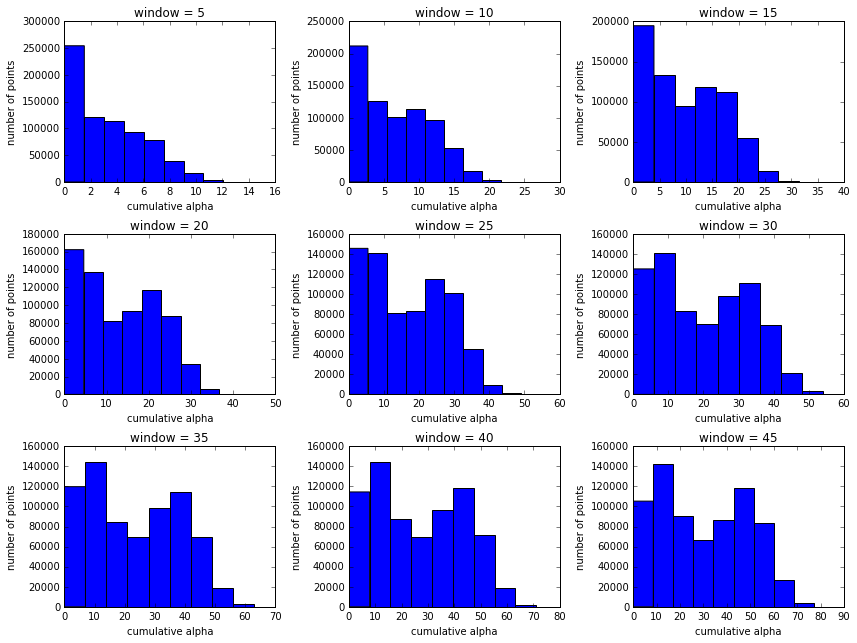

In [18]:
f, a = plt.subplots(3,3, figsize=(12,9))
a = a.ravel()

for idx,ax in enumerate(a):
    window = (idx+1) * 5    
    df['cum_alpha'] = df['alpha'].rolling(window=window).sum()
    ax.hist(df['cum_alpha'].fillna(0))
    ax.set_title('window = {}'.format(window))
    ax.set_xlabel('cumulative alpha')
    ax.set_ylabel('number of points')
plt.tight_layout()

count    722515.000000
mean          0.669827
std           0.841114
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max           3.141593
Name: alpha, dtype: float64


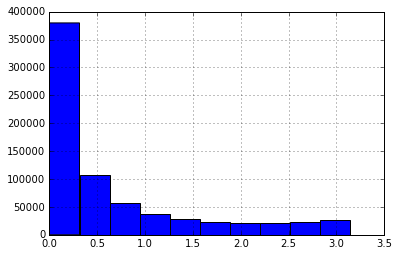

In [16]:
print df['alpha'].describe()
df['alpha'].hist()

### plot of points with big direction change/alpha

In [15]:
df_big_angle = df[df['alpha'] > (np.pi/2)]
print len(df_big_angle)

# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    geoplotlib.add_layer(LineLayer(grp_df))

# dot plot of all possible jump points
geoplotlib.dot(df_big_angle)
geoplotlib.show()

113385


## Calculate bounding box diagonal for different windows and plot result

window 5
window 10
window 15
window 20
window 25
window 30
window 35
window 40
window 45


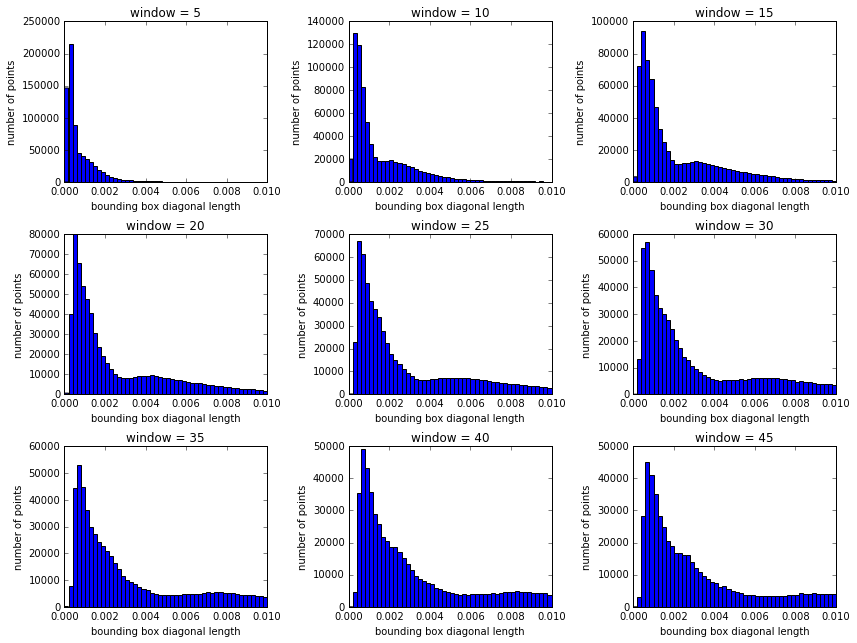

In [49]:
f, a = plt.subplots(3,3, figsize=(12,9))
a = a.ravel()

for idx,ax in enumerate(a):
    window = (idx+1) * 5
    
    groups = df.groupby('trID')
    frames = []
    print 'window', window
    for grp_id, grp_df in groups:
        tmp_df = grp_df.copy()
        tmp_df['min_bounding_lat'] = tmp_df['lat'].rolling(window=window).min()
        tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
        tmp_df['min_bounding_lon'] = tmp_df['lon'].rolling(window=window).min()
        tmp_df['max_bounding_lon'] = tmp_df['lon'].rolling(window=window).max()
        tmp_df['bb_diag'] = ((tmp_df['max_bounding_lon'] - tmp_df['min_bounding_lon'])**2 + (tmp_df['max_bounding_lat'] - tmp_df['min_bounding_lat'])**2)**0.5
        frames.append(tmp_df)
    df = pd.concat(frames)
    ax.hist(df['bb_diag'].dropna(), bins=50, range=(0,0.01))
    ax.set_title('window = {}'.format(window))
    ax.set_xlabel('bounding box diagonal length')
    ax.set_ylabel('number of points')
plt.tight_layout()


#### Plot points above given bb_diag threshold for a given trajectory

In [50]:
bb_thresh = 0.002
trj_df = df[df['trID'] == '128_ 26_1']

geoplotlib.add_layer(LineLayer(trj_df))
bb_small_dict = DataAccessObject.from_dataframe(trj_df[trj_df['bb_diag'] < bb_thresh])

def diag_tooltip(p):
    return "diag: {} trid: {}".format(np.round(p['bb_diag'], 4), p['trID'])
geoplotlib.dot(bb_small_dict, color=[255,0,0], f_tooltip=diag_tooltip)
geoplotlib.show()

#### Plot trajectory after filtering

In [51]:
bb_thresh = 0.002
trj_df = df[df['trID'] == '128_ 26_1']

geoplotlib.add_layer(LineLayer(trj_df[trj_df['bb_diag'] >= bb_thresh]))
geoplotlib.show()

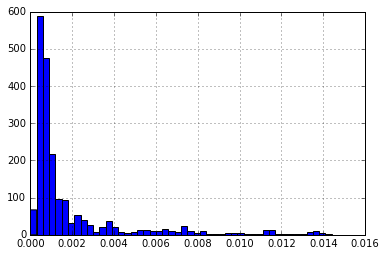

In [70]:
trj_df['bb_diag'].hist(bins=50, range=(0,0.015))

### Plot classes using one threshold for the whole dataset

In [52]:
bb_thresh = 0.0018

# line plot of trajectories
groups = df.groupby('trID')
for grp_id, grp_df in groups:
    grp_df = grp_df.iloc[:-1]
    small_bb = grp_df[grp_df['bb_diag'] < bb_thresh]
    big_bb = grp_df[grp_df['bb_diag'] >= bb_thresh]
    if len(small_bb) > 0:
        geoplotlib.graph(small_bb, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[255,0,0])
    if len(big_bb) > 0:
        geoplotlib.graph(big_bb, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,0,255])
geoplotlib.show()

## smoothed trajectory using average filter

In [54]:
window = 5

groups = df.groupby('trID')
frames = []
for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['avg_lat'] = tmp_df['lat'].rolling(window=window).mean()
    tmp_df['avg_lon'] = tmp_df['lon'].rolling(window=window).mean()
    frames.append(tmp_df)
df = pd.concat(frames)
smooth_df = df[['trID', 'avg_lat', 'avg_lon']]
smooth_df.rename(columns={"avg_lat": "lat", "avg_lon": "lon"}, inplace=True)
ax.set_title('window = {}'.format(window))
ax.set_xlabel('bounding box diagonal length')
ax.set_ylabel('number of points')

smooth_trj_df = smooth_df[smooth_df['trID'] == '128_ 26_1']
display(smooth_trj_df.dropna().head())

c:\program files\python27\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,trID,lat,lon
2011-11-06 12:45:44,128_ 26_1,54.994718,-1.660492
2011-11-06 12:45:49,128_ 26_1,54.994423,-1.659993
2011-11-06 12:45:54,128_ 26_1,54.994130,-1.659505
2011-11-06 12:45:59,128_ 26_1,54.993869,-1.659077
2011-11-06 12:46:04,128_ 26_1,54.993641,-1.658694


#### plot smoothed and original trajectory

In [55]:
geoplotlib.add_layer(LineLayer(df[df['trID'] == '128_ 26_1'], color=[0,0,255]))
geoplotlib.add_layer(LineLayer(trj_df.dropna(), color=[255,0,0]))
geoplotlib.show()

## bounding box diagonal on smoothed data

window 15


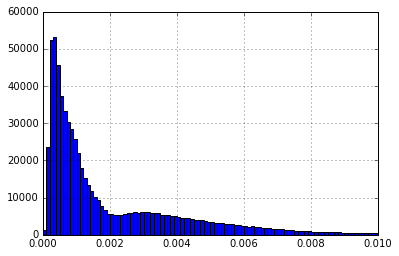

In [58]:
window = 15

groups = smooth_df.groupby('trID')
frames = []
print 'window', window
for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['min_bounding_lat'] = tmp_df['lat'].rolling(window=window).min()
    tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
    tmp_df['min_bounding_lon'] = tmp_df['lon'].rolling(window=window).min()
    tmp_df['max_bounding_lon'] = tmp_df['lon'].rolling(window=window).max()
    tmp_df['bb_diag'] = ((tmp_df['max_bounding_lon'] - tmp_df['min_bounding_lon'])**2 + (tmp_df['max_bounding_lat'] - tmp_df['min_bounding_lat'])**2)**0.5
    frames.append(tmp_df)
smooth_df = pd.concat(frames)
smooth_df['bb_diag'].hist(bins=100, range=(0,0.01))

#### Bounding Box diagonal thresholding on smoothed data

In [59]:
bb_thresh = 0.0018

smooth_df[['lon+1', 'lat+1']] = smooth_df[['lon', 'lat']].shift(-1)

groups = smooth_df.groupby('trID')
for grp_id, grp_df in groups:
    grp_df = grp_df.iloc[:-1]
    small_bb = grp_df[grp_df['bb_diag'] < bb_thresh]
    big_bb = grp_df[grp_df['bb_diag'] >= bb_thresh]
    if len(small_bb) > 0:
        geoplotlib.graph(small_bb, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[255,0,0])
    if len(big_bb) > 0:
        geoplotlib.graph(big_bb, src_lat='lat', src_lon='lon',
                         dest_lat='lat+1', dest_lon='lon+1', color=[0,0,255])
geoplotlib.show()

#### thresholding on a single trajectory

In [61]:
bb_thresh = 0.002

trj_df = smooth_df[smooth_df['trID'] == '128_ 26_1']
geoplotlib.add_layer(LineLayer(trj_df.dropna()))
bb_small_dict = DataAccessObject.from_dataframe(trj_df[trj_df['bb_diag'] < bb_thresh])

def diag_tooltip(p):
    return "diag: {} trid: {}".format(np.round(p['bb_diag'], 4), p['trID'])

geoplotlib.dot(bb_small_dict, color=[255,0,0], f_tooltip=diag_tooltip)
geoplotlib.show()

window 15


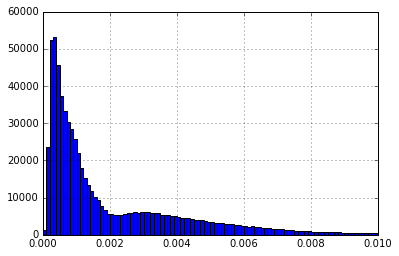

In [62]:
window = 15

groups = smooth_df.groupby('trID')
frames = []
print 'window', window
for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['min_bounding_lat'] = tmp_df['lat'].rolling(window=window).min()
    tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
    tmp_df['min_bounding_lon'] = tmp_df['lon'].rolling(window=window).min()
    tmp_df['max_bounding_lon'] = tmp_df['lon'].rolling(window=window).max()
    tmp_df['bb_diag'] = ((tmp_df['max_bounding_lon'] - tmp_df['min_bounding_lon'])**2 + (tmp_df['max_bounding_lat'] - tmp_df['min_bounding_lat'])**2)**0.5
    frames.append(tmp_df)
smooth_df = pd.concat(frames)
smooth_df['bb_diag'].hist(bins=100, range=(0,0.01))## Series of bounding box centers

## Series of bounding box centers

In [63]:
window = 15

groups = df.groupby('trID')
frames = []
print 'window', window
for grp_id, grp_df in groups:
    tmp_df = grp_df.copy()
    tmp_df['min_bounding_lat'] = tmp_df['lat'].rolling(window=window).min()
    tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
    tmp_df['max_bounding_lat'] = tmp_df['lat'].rolling(window=window).max()
    tmp_df['min_bounding_lon'] = tmp_df['lon'].rolling(window=window).min()
    
    tmp_df['bb_center_lat'] = (tmp_df['min_bounding_lat'] + tmp_df['max_bounding_lat']) / 2
    tmp_df['bb_center_lon'] = (tmp_df['min_bounding_lon'] + tmp_df['max_bounding_lon']) / 2
    
    frames.append(tmp_df)
tmp_df = pd.concat(frames)
bb_center_df = tmp_df[['trID', 'bb_center_lat', 'bb_center_lon']]
bb_center_df.rename(columns={"bb_center_lat": "lat", "bb_center_lon": "lon"}, inplace=True)

window 15


### plot original trajectory against trajectory of bounding box centers

In [64]:
geoplotlib.add_layer(LineLayer(bb_center_df[bb_center_df['trID'] == '128_ 26_1'].dropna(), color=[255,0,0]))
geoplotlib.add_layer(LineLayer(df[df['trID'] == '128_ 26_1'], color=[0,0,255]))
geoplotlib.show()

In [65]:
df.columns

Index([u'trID', u'trN', u'pIdx', u'lon', u'lat', u'time', u'lon+1', u'lat+1',
       u'v_lon', u'v_lat', u'norm_v_lon', u'norm_v_lat', u'norm_v_lon-1',
       u'norm_v_lat-1', u'alpha', u'cum_alpha', u'time+1', u'duration',
       u'distance', u'velocity', u'min_bounding_lat', u'max_bounding_lat',
       u'min_bounding_lon', u'max_bounding_lon', u'bb_diag', u'avg_lat',
       u'avg_lon'],
      dtype='object')

In [69]:
# draw_id = '200_  4_1'
# draw_id = '128_ 26_1'
draw_id = '208_  3_1'
# draw_id = '160_  7_1'

#### velocity plot for a single trajectory

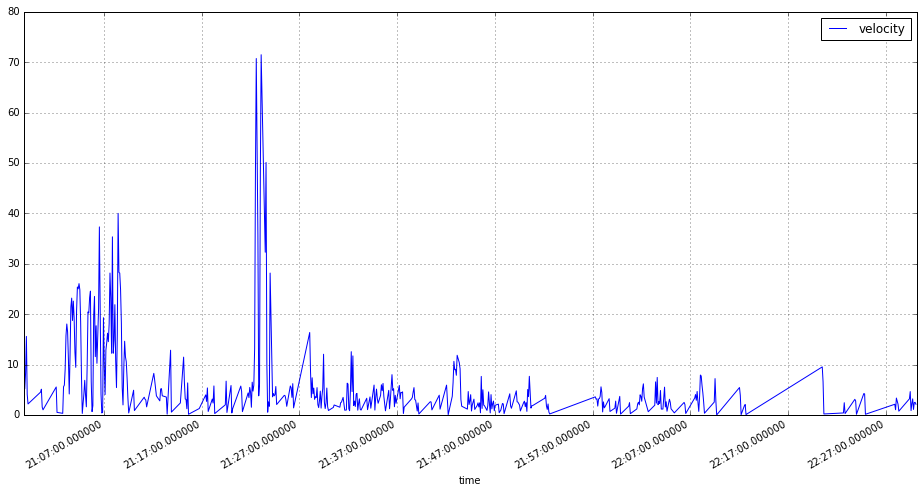

In [230]:
df[df['trID'] == draw_id].plot(x='time', y='velocity', figsize=(16,8))
plt.grid()

#### draw line segments in a given time window

In [ ]:
geoplotlib.add_layer(LineLayer(df[df['trID'] == draw_id].between_time('21:27', '22:27'), color=[0,0,255]))

# geoplotlib.add_layer(LineLayer(df[df['trID'] == draw_id].between_time('21:07', '21:27'), color=[0,0,255]))
geoplotlib.show()

In [70]:
v_threshold = 5

draw_df = df[df['trID'] == draw_id]
slow_df = draw_df[draw_df['velocity'] < v_threshold]
fast_df = draw_df[draw_df['velocity'] >= v_threshold]
if len(slow_df) > 0:
    geoplotlib.graph(slow_df, src_lat='lat', src_lon='lon',
                     dest_lat='lat+1', dest_lon='lon+1', color=[0,0,255])
if len(fast_df) > 0:
    geoplotlib.graph(fast_df, src_lat='lat', src_lon='lon',
                     dest_lat='lat+1', dest_lon='lon+1', color=[255,0,0])

geoplotlib.show()

In [239]:
draw_df = df[df['trID'] == draw_id]

if len(draw_df) > 0:
    geoplotlib.add_layer(LineLayer(draw_df, color=[0,0,255]))
    geoplotlib.show()
else:
    print 'no data'

### Find ids, id parts given

In [219]:
tmp_df = df[df['trID'].str.contains('160_ ') & df['trID'].str.contains(' 7_1')]
print tmp_df['trID']

2011-10-28 19:48:37    160_  7_1
2011-10-28 19:48:42    160_  7_1
2011-10-28 19:48:47    160_  7_1
2011-10-28 19:48:52    160_  7_1
2011-10-28 19:48:57    160_  7_1
2011-10-28 19:49:02    160_  7_1
2011-10-28 19:49:07    160_  7_1
2011-10-28 19:49:12    160_  7_1
2011-10-28 19:49:17    160_  7_1
2011-10-28 20:05:12    160_  7_1
2011-10-28 20:05:17    160_  7_1
2011-10-28 20:05:22    160_  7_1
2011-10-28 20:05:52    160_  7_1
2011-10-28 20:05:57    160_  7_1
2011-10-28 20:06:02    160_  7_1
2011-10-28 20:06:07    160_  7_1
2011-10-28 20:06:12    160_  7_1
2011-10-28 20:06:27    160_  7_1
2011-10-28 20:06:32    160_  7_1
2011-10-28 20:06:37    160_  7_1
2011-10-28 20:06:42    160_  7_1
2011-10-28 20:06:47    160_  7_1
2011-10-28 20:06:52    160_  7_1
2011-10-28 20:06:57    160_  7_1
2011-10-28 20:07:02    160_  7_1
2011-10-28 20:07:07    160_  7_1
2011-10-28 20:07:12    160_  7_1
2011-10-28 20:07:17    160_  7_1
2011-10-28 20:07:22    160_  7_1
2011-10-28 20:07:27    160_  7_1
          